In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import sqlite3
import pandas as pd
import networkx as nx
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
DATABASE = 'hw1_test.sqlite'

# papers = []
# authors = []
# conn = sqlite3.connect(DATABASE,timeout=10)
# for row in conn.execute('SELECT * FROM paper'):
#     papers.append({'id':row[0],'paper_name':row[1]})
# conn.close()

In [3]:

def Select_All(db,table,field):
    results = []
    conn = sqlite3.connect(DATABASE,timeout=10)
    for row in conn.execute('SELECT * FROM {}'.format(table)):
        results.append({'id':row[0],field:row[1]})
    conn.close()
    return results
    
def Flat_Dataframe(db):
    DATABASE = db
    query_pair_papers = """
    SELECT  ap.author_id,
            a.author_name,
            ap.paper_id,
            p.paper_name
    FROM author_paper AS ap
    INNER JOIN author AS a ON ap.author_id = a.id
    INNER JOIN paper AS p ON ap.paper_id = p.id
    """
    conn = sqlite3.connect(DATABASE, timeout=10)
    df = []
    for row in conn.execute(query_pair_papers):
        df.append(row)
    conn.close()
    df = pd.DataFrame(df,columns=['author_id','authors','paper_id','paper_name'])
    df['author_id'] = df['author_id'].apply(lambda x: int(x))
    df['paper_id'] = df['paper_id'].apply(lambda x: int(x))
    return df

def Generate_Edges_Authors(db):
    DATABASE = db
# Cria lista de arestas para rede de autores
    query_pair_authors = """
    SELECT paper_id,
           a1.author_id AS author1,
           a2.author_id AS author2
    FROM author_paper AS a1
    JOIN author_paper AS a2 USING (paper_id)
    WHERE a1.author_id < a2.author_id;
    """
    conn = sqlite3.connect(DATABASE,timeout=10)
    edges_authors = []
    for row in conn.execute(query_pair_authors):
        edges_authors.append(row)
    conn.close()
    edges_authors= pd.DataFrame(edges_authors,dtype=int,columns=['paper','author1',
                                                                 'author2']).applymap(lambda x: int(x))
    
    count_authors = edges_authors.groupby(['author1','author2']).count().reset_index()
    return count_authors


def Generate_Edges_Papers(db):
    DATABASE = db
# Cria lista de arestas para rede de papers
    query_pair_papers = """
    SELECT author_id,
           a1.paper_id AS paper1,
           a2.paper_id AS paper2
    FROM author_paper AS a1
    JOIN author_paper AS a2 USING (author_id)
    WHERE a1.paper_id < a2.paper_id;
    """
    conn = sqlite3.connect(DATABASE, timeout=10)
    edges_papers = []
    for row in conn.execute(query_pair_papers):
        edges_papers.append(row)
    conn.close()
    edges_papers = pd.DataFrame(edges_papers,dtype = int,columns=['author',
                                                      'paper1','paper2']).applymap(lambda x: int(x))
    
    count_papers  = edges_papers.groupby(['paper1','paper2']).count().reset_index()
    
    return count_papers
    

def Create_Network(nodes,edges,source='source', target='target',weight='weight'):
    G = nx.Graph()
    
    for d in nodes:
        node_id = int(d['id'])
        G.add_node(node_id, **d) 
    
    for d in edges.to_dict('records'):
        G.add_edge(d[source],d[target],count = d[weight])
    
    pos = nx.spring_layout(G)
    pos = pd.DataFrame(pos).transpose()
    
    pos['id'] = pos.index
    pos.columns = ['x','y','id']

    
    return (G, pos)

In [4]:
authors       = Select_All(DATABASE,table='author',field='author_name')
papers        = Select_All(DATABASE,table='paper',field='paper_name')
edges_authors = Generate_Edges_Authors(DATABASE) 
edges_papers  = Generate_Edges_Papers(DATABASE) 
df            = Flat_Dataframe(DATABASE)

In [6]:
G_authors, pos_authors = Create_Network(authors,edges_authors,'author1','author2','paper')
G_papers, pos_papers   = Create_Network(papers,edges_papers,'paper1','paper2','author')

# Implementando em Altair

In [7]:
# pd.DataFrame(index=range(G_authors.size()*2))
def Grafos_Edges(G,pos):
    pairs = []
    for e1, e2 in G.edges:
        pairs.append([e1,e2,str(e1)+','+str(e2)])
    for e1, e2 in G.edges:
        pairs.append([e2,e1,str(e1)+','+str(e2)])
    
    pairs =  pd.DataFrame(pairs,columns=['id','id_','pair'])

    return pd.merge(pos,pairs,on='id')

In [8]:
graf_egdes_authors = Grafos_Edges(G_authors,pos_authors)
graf_egdes_papers  = Grafos_Edges(G_papers,pos_papers)

In [9]:
# def Grafos_Nodes(G)
df = pd.merge(df,pos_authors,left_on='author_id',right_on='id',how='left')
df = pd.merge(df,pos_papers,left_on='paper_id',right_on='id',suffixes=('_a','_p'),how='left')

In [10]:
df.head()

,author_id,authors,paper_id,paper_name,x_a,y_a,id_a,x_p,y_p,id_p
0,11,RS Targino,1,Sequential Monte Carlo samplers for capital al...,-0.61728,0.119752,11,0.279115,-0.040195,1
1,11,RS Targino,2,Understanding operational risk capital approxi...,-0.61728,0.119752,11,0.213658,-0.085246,2
2,11,RS Targino,3,Optimal exercise strategies for operational ri...,-0.61728,0.119752,11,0.243364,-0.050319,3
3,11,RS Targino,5,Full bayesian analysis of claims reserving unc...,-0.61728,0.119752,11,0.267970,-0.073525,5
4,11,RS Targino,6,Bayesian Approach for Parameter Estimation of ...,-0.61728,0.119752,11,0.176573,-0.013779,6


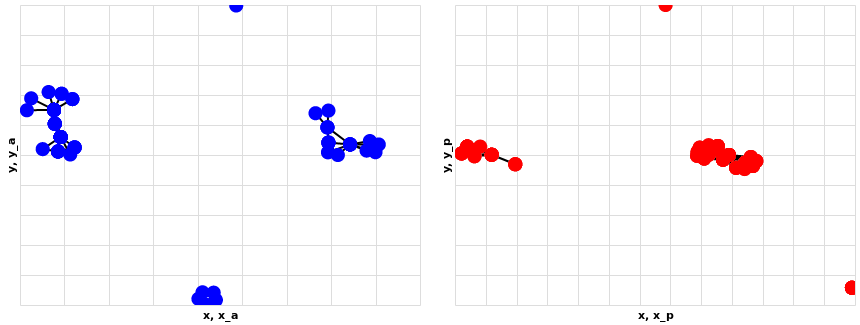

In [38]:
select = alt.selection_multi(fields=['authors'])

chart_na = alt.Chart(df).mark_circle(size=200).encode(
    x = 'x_a',
    y = 'y_a',
    fill = alt.condition(select,alt.value('blue'),alt.value('lightgray')),
    opacity = alt.value(1),
    tooltip = 'authors'
).properties(selection=select)


chart_np = alt.Chart(df).mark_circle(size=200).encode(
    x = 'x_p',
    y = 'y_p',
    fill = alt.value('red'),
    opacity = alt.condition(select,alt.value(1),alt.value(0.0)),
    tooltip = 'paper_name'
)
chart_np_background = alt.Chart(df).mark_circle(size=200).encode(
    x = 'x_p',
    y = 'y_p',
    fill = alt.value('lightgray'),
    opacity = alt.value(1),
    tooltip = 'paper_name'
)

chart_ea = alt.Chart(graf_egdes_authors).mark_line().encode(
    x = 'x',
    y = 'y',
    opacity = alt.value(1),
    color   = alt.value('black'),
    detail='pair'
).interactive()

chart_ep = alt.Chart(graf_egdes_papers).mark_line().encode(
    x = 'x',
    y = 'y',
    opacity = alt.value(1),
    color=alt.value('black'),
    detail='pair'
).interactive()

chart = chart_ea + chart_na | chart_ep + chart_np_background + chart_np

chart.configure_axis(
    
    ticks=False,
    grid=True,
    domain=False,
    labels=False).configure_view(strokeWidth=0)

In [12]:
df[df['authors']=='TRSM Nogueira']

,author_id,authors,paper_id,paper_name,x_a,y_a,id_a,x_p,y_p,id_p
76,27,TRSM Nogueira,26,Nomeação de coalizão﻿,0.021404,-0.91549,27,0.589993,-0.885008,26


In [60]:
df[df['paper_id']==26]

,author_id,authors,paper_id,paper_name,x_a,y_a,id_a,x_p,y_p,id_p
74,25,RE Glezer,26,Nomeação de coalizão﻿,0.885906,-0.042567,25,0.010565,0.744124,25.0
75,28,VH Thorstensen,26,Nomeação de coalizão﻿,0.841726,0.002488,28,NaN,NaN,NaN
76,27,TRSM Nogueira,26,Nomeação de coalizão﻿,0.894405,0.034211,27,NaN,NaN,NaN
77,16,D Campello,26,Nomeação de coalizão﻿,0.931134,-0.033490,16,0.000589,-0.214722,16.0
78,18,EM Almeida,26,Nomeação de coalizão﻿,0.936239,0.016859,18,0.011853,-0.154134,18.0
